In [44]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import clean_reviews as clean
import sklearn
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm
tqdm.pandas()

In [4]:
#scikit version must be at least 1.0 
# !pip install scikit-learn==1.0.2
print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))
0.14.1

The nltk version is 3.6.5.
The scikit-learn version is 0.24.2.


In [2]:
df = pd.read_csv('./amz_tshirt_reviews.csv')

In [38]:
df.shape

(20026, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40521 entries, 0 to 40520
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  40521 non-null  object 
 1   attr          0 non-null      float64
 2   scores        40441 non-null  object 
 3   review_title  40441 non-null  object 
 4   reviews       40521 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.5+ MB


In [77]:
df.isnull().sum().sort_values(ascending = False)

attr            40521
scores             80
review_title       80
product_name        0
reviews             0
dtype: int64

In [95]:
df.sample(5)

,product_name,attr,scores,review_title,reviews
10814,Russell Athletic Men's Cotton Performance Short Sleeve T-Shirt,NaN,5.0 out of 5 stars,"\nNot all the same length,\n","<span class=""a-size-base review-text review-text-content"" data-hook=""review-body"">\n<span>\n Most of the shirts are long tail that came in the sets. But the blue ones were short.\n</span>\n</span>"
18928,Amazon Essentials Women's 2-Pack V-Neck Classic-fit Short-Sleeve Tee Shirt,NaN,3.0 out of 5 stars,"\nGreat shirt, not for short girls\n","<span class=""a-size-base review-text review-text-content"" data-hook=""review-body"">\n<span>\n These shirts are really soft and comfy but may not work for short girls. I got a small and it hit over the bottom of my shorts. With that much excess material I wouldn't be able to tuck them in either. I do not think sizing down would fix the length issue but if Amazon puts out a petite's basics I would not hesitate to order.\n</span>\n</span>"
21485,Hanes Women's Shirred V-Neck T-Shirt,NaN,5.0 out of 5 stars,\nShirt\n,"<span class=""a-size-base review-text review-text-content"" data-hook=""review-body"">\n<span>\n Nice shirt\n</span>\n</span>"
3479,"Gildan Men's Ultra Cotton Long Sleeve T-Shirt, Style G2400, Multipack",NaN,4.0 out of 5 stars,\nFits well\n,"<span class=""a-size-base review-text review-text-content"" data-hook=""review-body"">\n<span>\n I bought a two pack for undershirts at work because I work the drive-through window the shirt is a little rough just putting it on straight out of the package, overall fit it’s a little bit longer than a regular T-shirt but shoulders and chest fit really well, I am 5”5 150 ish pounds The sleeves are a little long but that could be just me having short arms.\n</span>\n</span>"
28404,"Gildan Men's Cotton Stretch Crew T-Shirts, 3-Pack",NaN,5.0 out of 5 stars,\nBest White Tees I've Worn Ever!\n,"<span class=""a-size-base review-text review-text-content"" data-hook=""review-body"">\n<span>\n By far the best white tees that I have purchased. I will continue sticking with these Gildan Stretch fits. They are Thick enough and not too thick as well has soft and comfortable. Repells moisture very well and really easy to keep clean and white longer. The collars don't seem to stretch like a lot of white tees I have purchased in the past and they stay true to size. Very minimal shrinking if any ..."


In [18]:
#increase the column width to be able to view long reviews 
pd.set_option('max_colwidth', 500)
df['reviews'].sample(2)

17241          high quality nice fabric i ordered a size up based on other reviews and they are slightly big but i like the way it fits and then do not fret about putting them in the dryer im a solid size  if you wanted fitted get l it want a little room get xl and put in dryer on low when washing i also like the xl because i can knot it at the bottom to do a cute tie up with jeans and still be work appropriate    
35773                                                         these are excellent everyday shirts even after several washes they have not shrunk or faded now for the down side somehow this color of amazon brand shirts develop holes in them one has five small holes the other has a hole the size of a quarter this is odd since the other colored shirts has no holes in then and they are worn the same just my luck eh    
Name: reviews, dtype: object

#### when I webscrapped the data, I had a bug that caused the 'attr' column to be null, I need to re-run the webscrapping ipynb file and get the complete dataset 

In [3]:
#drop attr column
df.drop('attr', axis = 1, inplace = True)

In [4]:
#drop rows with all null values 
df = df.dropna(axis = 0, subset= ['reviews', 'review_title', 'scores'])

In [5]:
#check for duplicates 
duplicate = df[df.duplicated()]
duplicate.shape


(20415, 4)

### aparently, half the data is duplicated. Must be a bug in the webscrapping script that stored each row twice. We will drop duplicates for now

In [6]:
#drop al duplicates then reset_index
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True)
df.drop(columns='index', inplace= True)


## Extract review score as int

In [7]:
#for null ratings, I will give a rating of 9 so I know later that they were unknown ratings
df.scores.fillna('9', inplace= True)
df.scores = df.scores.str.slice(start = 0, stop =1)

## clean 'reviews' & 'review_title' column from <>, \n, punctuations


In [9]:

df.reviews = df.reviews.progress_apply(clean.clean)
df.review_title = df.review_title.progress_apply(clean.clean)

100%|██████████| 20026/20026 [00:05<00:00, 3982.12it/s]


### Change datatypes

In [18]:
# using dictionary to convert specific columns
convert_dict = {'product_name': str,
				'review_title' : str,
                'reviews' : str,
                'scores' : int
               }
df = df.astype(convert_dict)

### Fill null 'review_title' based on score or review 

In [19]:
#this function checks if the title is empty or == 'nan', then -> it will check the score and convert it into word based on the rating_dict. 
# If the score is 9 (which means null), it will take the first sent in the review  
# 'nan' means null, and it results from the clean method


def create_title(title, score, review):

    rating_dict = {5:'perfect', 4: 'good', 3: 'ok', 2: 'bad', 1: 'terrible'}
    x = ''
    if (title == 'nan') or (title.strip() == ''):

        if (score < 9):
            x = rating_dict[int(score)]
        else:

            if bool(review.strip().split('.')[0]) :
                x = review.split('.')[0]
                x = " ".join(x.strip().split(" ")[0:10])
            else:

                x = " ".join(review.strip().split(" ")[0:10])
        return x
    else:
        return title
    


In [20]:
#apply create_title
df['review_title'] = df.apply(lambda x: create_title(x['review_title'], x['scores'], x['reviews']), axis = 1)

In [22]:
df.sample(10)

,product_name,scores,review_title,reviews
7433,Hanes Women’s Perfect-T Short Sleeve T-shirt,5,i really like my shirt,i got a small i’m usually an xsmall but i want...
14972,Hanes Men's Short Sleeve Beefy-T (Pack of 2),4,nice shirts in quality but feel baggy,familiar with the brand for years shirts are ...
1021,Hanes Men's Essentials Short Sleeve T-shirt Va...,1,shrinks horribly,femalethese shirts shrink like nothing i have ...
11530,"Champion Men's Classic T-Shirt, Screen Print S...",5,tiene muy buena tela y es bonito,a mi nieto le gusto mucho
9420,"Gildan Women's Softstyle Cotton T-Shirt, Style...",1,too small,i saw a what i thought was a good rating but s...
4621,Champion Men's Classic Jersey Tee,1,do not order,i originally purchased a size large grey shirt...
9042,Amazon Essentials Women's 2-Pack V-Neck Classi...,5,great fit great fabric,i love these shirts they are thick and very we...
3582,"Gildan Men's Heavy Cotton T-Shirt, Style G5000...",2,not a heavy weight shirt,this was a disappointing purchase in that the ...
10859,Gildan Men's DryBlend Workwear T-Shirts with P...,4,size runs slightly small compared to haines or...,i purchased these shirts because they were in ...
8174,Hanes Men’s Short Sleeve Graphic T-shirt Colle...,5,heavy material,heavier cotton than what expected gifted with...


# How many products does this dataset have? 

In [12]:
df.product_name.nunique()

46

# What is the distribution of scores 

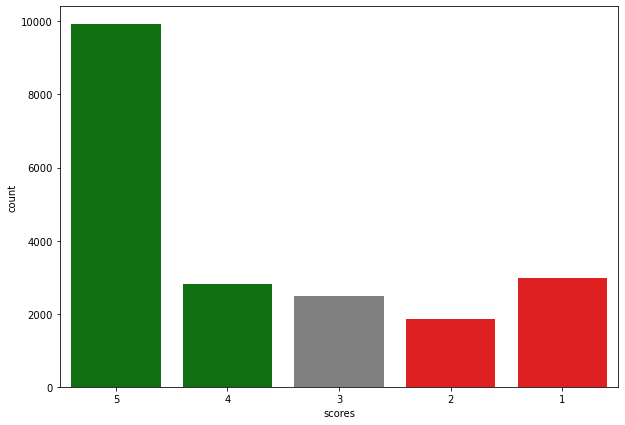

In [24]:
clrs = ['green', 'green', 'grey', 'red', 'red']
sns.countplot( data = df, x = 'scores', order = [5, 4, 3, 2, 1], palette=clrs)
# sb.barplot(x=idx, y=values, palette=clrs) # color=clrs)
plt.gcf().set_size_inches(10, 7)



## most of the reviews are 4 and 5 stars.
#### Since we only have few for 1 and 2 stars, I will consider 3 stars as a negative review. I will create a new boolean column called 'like' which answers the question: 'did the customer like the product or not?'
- 'yes': for 4 & 5 stars ratings
- 'no' :  for 3, 2, and 1 stars 

In [25]:
#create 'like' column
df.scores = df.scores.astype(int)
def like(x):
    x = int(x)
    if x > 8:
        return None
    else:
        return x > 3

df['like'] = df.scores.apply(like)
# df['like'] = df['like'].astype(bool)

<AxesSubplot:xlabel='like', ylabel='count'>

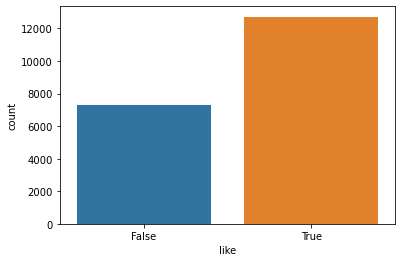

In [26]:
sns.countplot(data=df, x = 'like')

### Extract brand from 'product_name'
##### it seems that the first word of the product_name is often the brand name, so we will create a column for that 

In [27]:
def get_brand(text):
    return text.split(" ")[0]

df['brand'] = df.product_name.progress_apply(get_brand)

100%|██████████| 20026/20026 [00:00<00:00, 35767.20it/s]


### Extract gneder from 'product_name'

In [28]:
def get_gender(text):
    if 'women' in text.lower():
        return 'women'
    elif 'men' in text.lower():
        return 'men'
    else:
        return 'not_specified'

df['gender'] = df['product_name'].progress_apply(get_gender)

100%|██████████| 20026/20026 [00:00<00:00, 35627.75it/s]


<AxesSubplot:xlabel='scores', ylabel='count'>

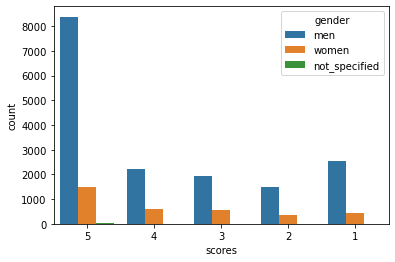

In [29]:
sns.countplot(data = df, x = 'scores', hue = 'gender', order = [5, 4, 3, 2, 1])

In [128]:
df.loc[df['brand'] == '5']

,product_name,attr,scores,review_title,reviews,like,brand
20000,5 Pack: Men’s Dry-Fit Moisture Wicking Active ...,nan,1,\nJUNK!\n,"<span class=""a-size-base review-text review-te...",False,5
20001,5 Pack: Men’s Dry-Fit Moisture Wicking Active ...,nan,3,\nBatch of five but different size between col...,"<span class=""a-size-base review-text review-te...",False,5
20002,5 Pack: Men’s Dry-Fit Moisture Wicking Active ...,nan,2,\nPoor Quality Control and Poorly Constructed\n,"<span class=""a-size-base review-text review-te...",False,5
20003,5 Pack: Men’s Dry-Fit Moisture Wicking Active ...,nan,1,\nWould not recommend\n,"<span class=""a-size-base review-text review-te...",False,5
20004,5 Pack: Men’s Dry-Fit Moisture Wicking Active ...,nan,1,\nXL is tiny\n,"<span class=""a-size-base review-text review-te...",False,5
...,...,...,...,...,...,...,...
20495,5 Pack: Men’s Dry-Fit Moisture Wicking Active ...,nan,3,"\nNice shirts, huge neck holes\n","<span class=""a-size-base review-text review-te...",False,5
20496,5 Pack: Men’s Dry-Fit Moisture Wicking Active ...,nan,5,\nThe neck stretched after washed\n,"<span class=""a-size-base review-text review-te...",True,5
20497,5 Pack: Men’s Dry-Fit Moisture Wicking Active ...,nan,2,\nColors not as pictured.\n,"<span class=""a-size-base review-text review-te...",False,5
20498,5 Pack: Men’s Dry-Fit Moisture Wicking Active ...,nan,2,"\nDecent material, but the sewing and cut of t...","<span class=""a-size-base review-text review-te...",False,5


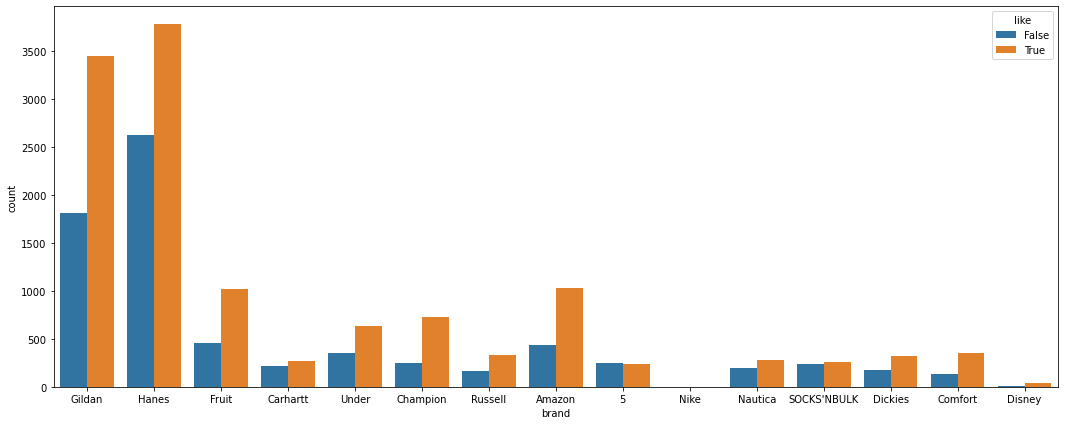

In [30]:
brands = sns.countplot(data = df, x = 'brand', hue = 'like')
plt.gcf().set_size_inches(18, 7)


## how many words per review

In [31]:
df['rev_len'] = df['reviews'].str.split().apply(len)


(0.0, 250.0)

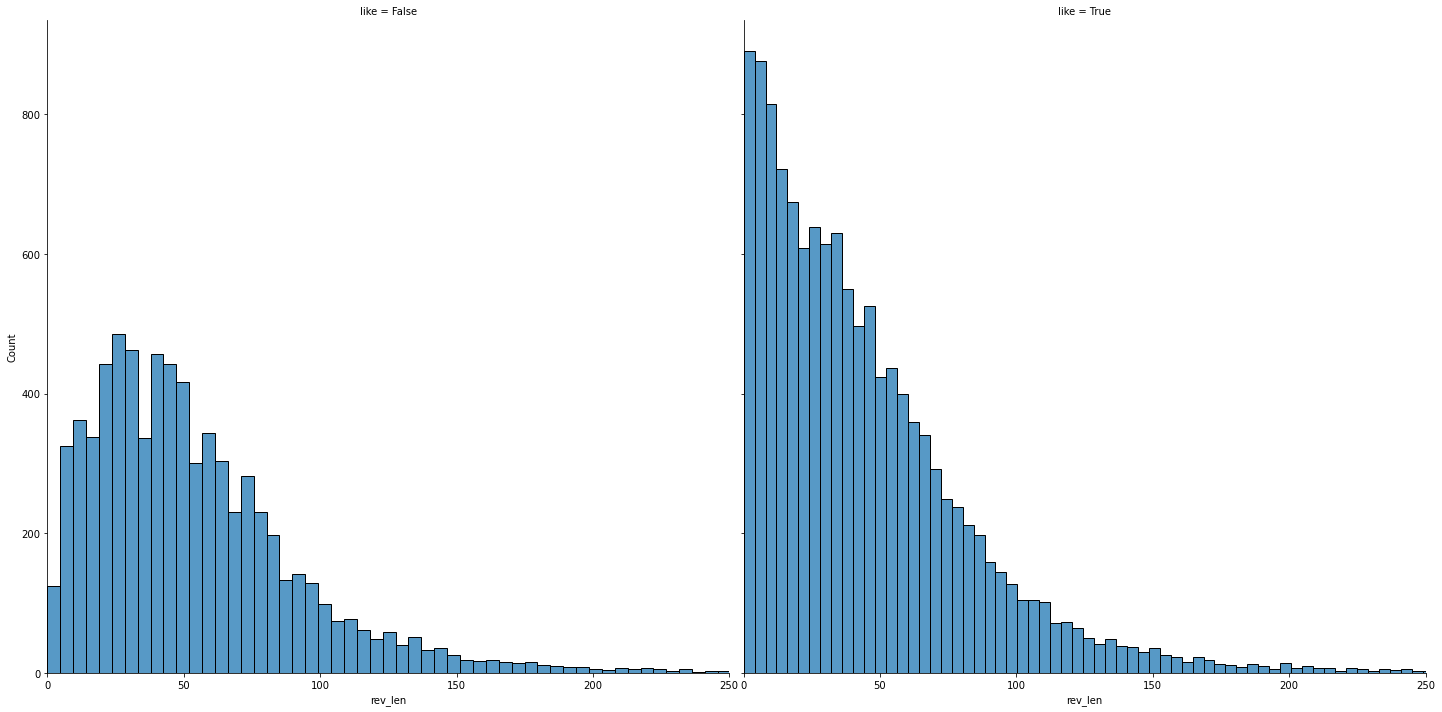

In [32]:
g = sns.FacetGrid(df, col ='like', height=10)
g.map(sns.histplot,'rev_len', linewidth = 1)
plt.xlim(0, 250)


I want to take the log and try to find mean and median for good/bad reviews 

In [15]:
df['only_eng'] = df.reviews.progress_apply(clean.only_english)

  8%|▊         | 3395/40521 [16:27<2:59:55,  3.44it/s] 


KeyboardInterrupt: 

In [14]:
df['eng_len'] = df['only_eng'].str.split().progress_apply(len)


KeyError: 'only_eng'

In [ ]:
sum(df['rev_len'] - df['eng_len'])


25320    <span class="a-size-base review-text review-text-content" data-hook="review-body">\n<span>\n  I had previously gotten Hanes "Our Most Comfortable" t-shirts for my husband. I thought these would be the same. NOT. The material, although still 100% cotton is almost scratchy. I washed these before wearing, and now I am on the lookout to find replacements. Apparently Hanes no longer makes the ones we have previously had. Very disappointed.\n</span>\n</span>
34948                                                                                                                                                                      <span class="a-size-base review-text review-text-content" data-hook="review-body">\n<span>\n  These t-shirts are so soft and comfortable.  Washed and dried them before first wear and they feel great and fit as expected!  Certainly recommend these for those soft tshirt lovers!\n</span>\n</span>
Name: reviews, dtype: object

In [22]:
# !pip install nlppreprocess

In [23]:
# I wanted to split the reviews into sentences but I realized I can do that with nltk
# df['reviews_splitted'] = df.reviews.apply(lambda x: re.split('[,.]', str(x)))

In [34]:
df.to_csv("./data/cleaned_reviews.csv", index = False)

### Lemmatization


In [41]:
wnl = WordNetLemmatizer()
word_tokenizer = nltk.tokenize.WhitespaceTokenizer()
def lem_text(text):
    return [wnl.lemmatize(w) for w in word_tokenizer.tokenize(text)]

df['lemmatized_title'] = df['review_title'].progress_apply(lem_text)
df['lemmatized_review'] = df['reviews'].progress_apply(lem_text)



100%|██████████| 20026/20026 [00:39<00:00, 503.00it/s] 


### stopwords


In [ ]:
all_stopwords = stopwords.words('english')

#there are important words in reviews that I don't want to remove, such as "size up" and "size down"
do_not_remove = ['not', 'no', 'up', 'down', 'above', 'below', 'off', 'again', 'too', 'y', 's', 't', 'o', 'd', 'm']
for word in all_stopwords:
    if (word in do_not_remove):
        all_stopwords.remove(word)

def remove_stopwords(text):
    return [word for word in text if word not in all_stopwords]

%store all_stopwords



In [ ]:
df['cleaned_review'] = df.lemmatized_review.progress_apply(remove_stopwords)
df['cleaned_title'] = df.lemmatized_title.progress_apply(remove_stopwords)

In [219]:
df['cleaned_review'] = df['cleaned_review'].str.join(" ")
df['cleaned_title'] = df['cleaned_title'].str.join(" ")

## Stemmer

In [70]:
ps = PorterStemmer()

corpus=[]

for title in df['review_title']:
    title = title.split()
    title = [ps.stem(word) for word in title if not word in set(all_stopwords)]
    title = ' '.join(title)
    corpus.append(title)




In [72]:
corpus[0:10]

['solid valu shirt',
 'pleas',
 'hem roll up look bad',
 'true xl no need go size up',
 'afford qualiti shirt',
 'thank',
 'cotton buy next size up',
 'great shirt',
 'great choic',
 'stiff wing sleev']

## CountVectorizer

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

all_titles = df['review_title'].to_list()
cv = CountVectorizer(stop_words= all_stopwords)
df_cv = cv.fit_transform(all_titles)
df_dtm = pd.DataFrame(df_cv.toarray()    # convert the matrix to an array 
                        , columns=cv.get_feature_names_out()   # name the columns
                        )

df_dtm.index = df.index


In [51]:
df_dtm.sum().sort_values(ascending = False).head(10)


great      2726
shirt      2548
not        2037
good       1999
shirts     1846
quality    1545
fit        1358
nice       1118
size        880
small       817
dtype: int64

In [52]:
all_titles = df['reviews'].to_list()
cv = CountVectorizer(stop_words= all_stopwords, max_df=2000)
df_cv = cv.fit_transform(all_titles)
df_dtm = pd.DataFrame(df_cv.toarray()    # convert the matrix to an array 
                        , columns=cv.get_feature_names_out()   # name the columns
                        )

df_dtm.index = df.index

In [53]:
df_dtm.sum().sort_values(ascending = False).head(10)


cotton     2710
long       2277
little     2239
color      2125
fits       2099
perfect    2071
no         1945
colors     1938
get        1929
fabric     1889
dtype: int64

In [ ]:
# # this code results in a very long and unuseful dict
# # # finding the most commen 30 words
# Top_words = {}
# for word in df_dtm.columns:
#     a = df_dtm[word].sort_values(ascending=False, na_position='last').head(30)
#     Top_words[word]= list(zip(a.index, a.values))



In [ ]:
# ! pip install -U wordcloud

## WordCloud


In [35]:
#add words to stopwords list 
add_words = ['shirt', 'fit', 'not', 'good', 'perfect', 'great', 'nice', 'love', 'like', 'wa', 'also', 'bought', 'would', 'one', 'well', 'get', 'really', 'color', 'even', 'ordered', 'husband', 'buy']
for word in add_words:
    all_stopwords.append(word)



NameError: name 'all_stopwords' is not defined

In [264]:


wc = WordCloud(stopwords=all_stopwords, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

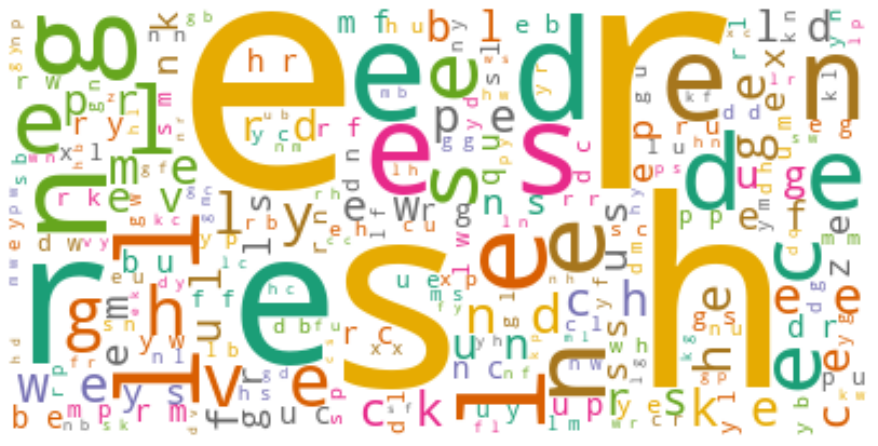

In [236]:

titles = " ".join(title for title in ' '.join(df.cleaned_title))
plt.rcParams['figure.figsize'] = [16, 6]

cloud = wc.generate(titles)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.imshow(cloud, interpolation='bilinear')
plt.show()


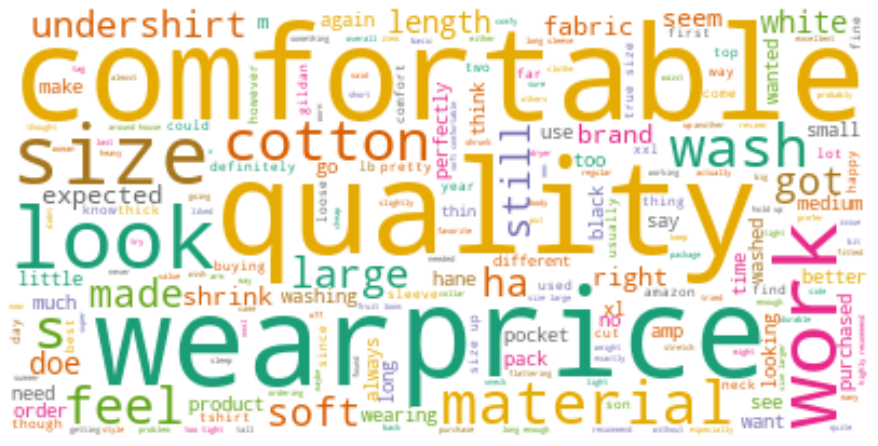

In [265]:
# create 2 wordclouds: positive and negative 

pos_rev = ' '.join([Text for Text in df[df['like'] == True]['cleaned_review']])
pos_cloud = wc.generate(pos_rev)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.imshow(pos_cloud, interpolation='bilinear')
plt.show()

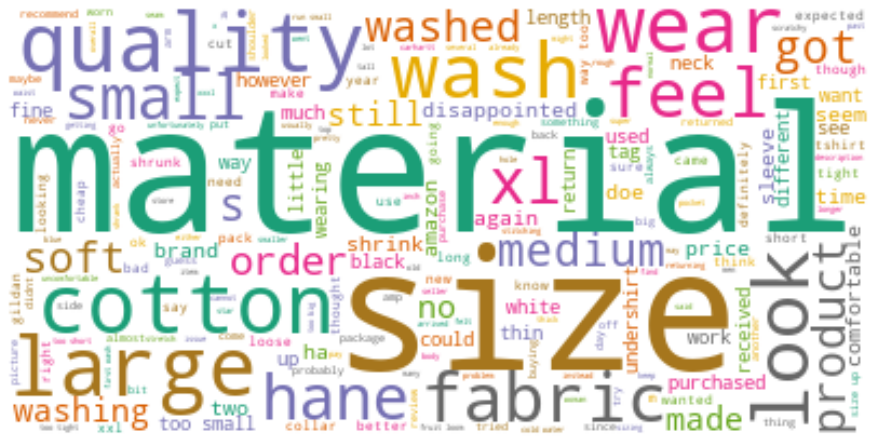

In [266]:
neg_rev = ' '.join([Text for Text in df[df['like'] == False]['cleaned_review']])
neg_cloud = wc.generate(neg_rev)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.imshow(neg_cloud, interpolation='bilinear')
plt.show()